## Lab 1 - Autoencoders and UNet 


In this lab we will investigate autoencoders and the UNet model. These models are commonly used in computer vision applications for image-to-image problems, i.e. when both the input and the output of the network is an image.

Autoencoders are usually used to learn a low-dimensional representation of the data (corresponding to the features at the bottleneck layer). However, we will not be using them in this sense today. Instead, we will implement both an autoencoder and a UNet, to highlight the similarity between these models (the UNet can be seen as a generalization of the autoencoder) and to exemplify the benefits conferred by the skip connections in the UNet.

To discover this difference, we will train both models on two separate image-to-image tasks in parallel:
1. **Denoising:** The input is a noisy version of the image and the task is to predict the noise-free clean image. Image denoising is an important problem on its own, not least for medical images that often suffer from low signal-to-noise ratio. However, it can also be used as a type of self-supervised pretraining task, since it is easy to generate noisy images from clean ones and then train a model to remove the noise. The encoder part of the model can then be used as a feature extractor in downstream tasks.  
2. **Semantic segmentation:** The input is a noise-free image and the task is to classify each pixel in the image according to a predetermined set of "semantic classes". This is a massive field of computer vision used for detecting the exact locations of target objects such as obstacles in self-driving vehicles, segmenting organs in medical images, and when we want to select a specific object from a scene (like a smart lasso in Apple Images and Adobe Photoshop).

### The GTAV data

To experiment with these models and tasks we will make use of synthetic road scene data obtained from the GTA game. [Richter et al.](https://arxiv.org/pdf/1608.02192v1.pdf) created the dataset by playing the game Grand Theft Auto V with a special asset hashing scheme that automatically outputs the image rendered as it would be in-game as well a mask determined by the asset type. The dataset is commonly used to train models for self-driving vehicles and driver assist AI, as the game is quite realistic, and collecting the huge amount of data in the dataset was much easier and faster than collecting real life data and paying annotators to segment the images by hand. 

For the lab, we have downscaled a small subset of the images and label-images (masks) and provided them both, as well as noisy versions of the images. The data is available in the zip file `/courses/TDDE70/labs/lab1/GTAV.zip`. Alternatively, if you work on your own computer you can download the files from Lisam. Unzip into the base folder for this notebook, so that the data files are available under `./GTAV/`.

This folder contains three subfolders: `images`, `noiseimages`, and `labels` for the clean images, noisy images, and semantic labels, respectively. 
For the segmentation task there are 20 ground-truth classes. 

The folder also contains plain text files with filenames for the suggested train and test splits.

### Structure of the lab

As mentioned above, we will work with both tasks (denoising and segmentation) in parallel and implement both models (autoencoder and UNet) for both of them. The main part of the lab is divided into three sections:
1. **Preparing the data:** In [Section 1](#1-preparing-the-data) we will create custom `Dataset` classes for the two tasks, to read the images from disk within the `DataLoader`s we learned about in the last lab. 
2. **Designing the models:** We will then construct our neural network models from the ground up using submodulization. We will start with the autoencoder in [Section 2](#2-autoencoder), and later adapt this to the UNet model in [Section 4](#4-unet). 
3. **Training and evaluation:** In [Section 3](#3-training-classes) we will design `Trainer` classes which house the training and testing loops and train the models using them. The lab includes plotting methodologies to qualitatively analyze how well our models work, as well as several quantitative methods to compare the two models. 

All of these parts constitute key components of the machine learning pipeline. In addition to learning about autoencoders and the UNet, a purpose of the lab is to provide you with some hands-on experience with these different components, which is why we will spend a fair bit of time also on the data preparation and training/testing functionality. 

There are some extra learning opportunities including an extra task at the end, which explores averaging model weights, as well as links to interesting further reading along the way for the curious mind. 

**Some things to take note of:**

- There are 6 demos which need to be completed correctly in order to complete the lab.
- There are 11 questions in the lab, which you should answer correctly in order to complete the lab.
- <span style="color:red">You may get cuda memory issues if you initialise too many models. If this happens, you can go to **Kernel > Restart Kernel...** in the toolbar and this will fix it (or type 0,0 while you have selected the outside a cell)</span>.

### Import libraries
All import statements should be contained here.

In [ ]:
import random
import math
import copy
import time
import os

import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
import numpy as np

from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.io import read_image
from torchvision.transforms import Resize
from torchvision.transforms import Compose, ToTensor, Lambda, Pad
from PIL import Image
nn = torch.nn
F = nn.functional

## 1. Preparing the data

To make our datasets, we will follow torch.utils.data.Dataset convention. This means we need to implement three methods: `__init__`, `__len__`, and `__getitem__`.

It is somewhat conventional in machine learning to call your inputs $x$ and your outputs $y$. For the denoising dataset, $x$ are noisy images, which look quite terrible, and $y$ are the denoised images.

For the segmentation dataset, $x$ are the same clean images we used as $y$ in the denoising dataset, and $y$ are classwise segmentation masks, where the greyscale pixel values represent the class a certain pixel is a part of (car, street, person, tree, background, etc.). 

#### Denoising Dataset

Read through these descriptions and make sure you understand how this denoising dataset works, you will be modifying it to make the segmentation dataset soon.

- `__init__`: This special method is nearly always included in a class, not just datasets, and is used to setup variables the dataset will need (it's a constructor). The argument, `self`, is always a reference to an object instantiated from the class, and is needed when defining attributes (variables that are part of the object) and methods (functions that are part of the object). There are things you can do with class variables instead but this is beyond the scope of the Lab. 

- `__len__`: This is used by torch to keep track of the total length of the dataset. We can easily return the size simply by returning `len(self.file_names)`.

- `__getitem__`: This method takes an index and returns the data. There is a lot of freedom with how you could set this up for many different types of tasks. In the denoising task for this lab, we will return a tuple containing the noise image and the clean image
   
To make plotting the images easier, we also defined the `get_plottable` method. This is nearly identical to `__getitem__` except for two things:
- we call `.permute(1,2,0)` on the images we read in with `read_image`.
  - This is necessary because matplotlib expects our image to be of the shape (height,width,channels) but they are read in by torch as (channels, height, width).
- This function returns the images in byte format (0-255) instead of float format (0.0-1.0)
  - Conveniently, this is how read_image returns them anyhow

In [ ]:
class GTAVDenoisingDataset(torch.utils.data.Dataset):
    def __init__(self, train=True): 
        self.file_names = []
        split = 'train' if train else 'test'
        with open(f'GTAV/{split}.txt','r') as f:
            entry = f.readline()
            while entry:
                self.file_names.append(entry.strip())
                entry = f.readline()
        
    def __len__(self): 
        ### returns the number of items in the dataset, nice and simple
        return len(self.file_names)

    def __getitem__(self, idx): 
        name = self.file_names[idx]
        ### of the form (x, y) the values are scaled by 255 and returned as type float
        sample = (read_image(f'./GTAV/noiseimages/{name}')/255., read_image(f'./GTAV/images/{name}')/255.)
        return sample 
        
    def get_plottable(self, idx): 
        ### Same deal as before but this time the images are permuted and not scaled
        name = self.file_names[idx]
        sample = read_image(f'./GTAV/noiseimages/{name}').permute(1,2,0), read_image(f'./GTAV/images/{name}').permute(1,2,0) 
        return sample 


#### Segmentation Dataset

The process for creating the Segmentation dataset is the same as the denoising dataset, with a few minor modifications. Check the comments in the included code to complete the GTAVSegmentationDataset.

In [ ]:
class GTAVSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, train=True): 
        ### Literally the same as the denoising init, 
        ### only you've been given an array to help plotting the masks
        self.semantic_colours = (torch.tensor([[0, 0, 0],[128, 64, 128],[244, 35,232],[70, 70, 70],
                                     [102,102,156],[190,153,153],[153,153,153],[250,170, 30],
                                     [220,220, 0],[107,142, 35],[152,251,152],[70,130,180],
                                     [220, 20, 60],[255,0,0],[0, 0,142],[0,0,70],[ 0, 60,100],
                                     [0, 80,100],[0,0,230],[119, 11, 32]])/255).tolist()

        self.file_names = []
        split = 'train' if train else 'test'
        with open(f'GTAV/{split}.txt','r') as f:
            entry = f.readline()
            while entry:
                self.file_names.append(entry.strip())
                entry = f.readline()
        
    
    def __len__(self): 
        return len(self.file_names)
       
   
    def __getitem__(self, idx): 
        name = self.file_names[idx]
        sample = sample = (read_image(f'./GTAV/images/{name}')/255., read_image(f'./GTAV/labels/{name}'))
        return sample 
        
    ### The segmentation label masks are image shaped but use pixel values as classes, 
    ### so they are kinda useless to look at, as all the 'pixels' are nearly black.
    ### This function will take either an index of a ground truth label mask
    ### or a predicted mask image and output a colour image 
    ### with the same colours as the original GTAV dataset.
    def get_plottable_mask(self, idx):
        ### 1 - Use the python function type() to check whether idx is an int or a tensor 
        ### 2 - if int, load the mask file 
        ###       (we don't have a function for this, but similar to __getitem__)
        ### 3 - else idx is already the tensor, we will set mask to it for cleaner code
        ### 4 - Either way, you will need to squeeze the 0th dimension 
        ###       since it is redundant for this step. (( .squeeze(0) ))
        
        if type(idx) == int: ### 1 - Modify this
            name = self.file_names[idx]
            sample = read_image(f'./GTAV/labels/{name}').permute(1,2,0) 
            sample = torch.stack(list(sample), dim=0)
            mask = sample.squeeze(0)
        else:
            mask = idx.squeeze(0) ## 3, 4 - Modify this
            
        ### 5 - Get the mask height and width and store them
        ###       The masks are stored as greyscale, (1,height, width)
        ###        and we squeezed the 0 dimension when we loaded them. 
        ### 6 - then flatten the mask tensor and turn it into a list. 
        ###        (torch.tensor functions, not python ones, else you will get a list of
        ###         tensors and not a list of floats)
      

# Check the size of each dimension
        print(mask.size())
        h, w = (mask.size(0), mask.size(1))
        #mask = torch.flatten(mask).squeeze()
        mask = mask.flatten().tolist()
        return torch.tensor([self.semantic_colours[i] for i in mask]).reshape((h, w, 3))
        
    def get_plottable_image(self, idx): 
        name = self.file_names[idx]
        sample = read_image(f'./GTAV/images/{name}').permute(1,2,0)/255.
        return sample 
        
    def plot_masked_im(self, idx):
        seg = self.get_plottable_mask(idx)
        im = self.get_plottable_image(idx)
        plt.imshow(im/3 + seg/3 * 2)

    ### This method uses other class methods defined in this class to plot both of
    ### the masks(, one predicted by the trained model 
    ### and the other the ground truth mask,) overlayed on the input image.
    ### By providing an image index and a model to predict with, 
    ### this method will plot two masked images.
    def plot_pred_masked_im(self, idx, model): 
        x, y = self[idx]
        pred = model.forward(x.to(device=model.device,dtype=torch.float).unsqueeze(0)).argmax(1)
        #self anropar __getitem__
        ### Make these plottable, you can use functions already in this class. 
        ### y and pred are masks, how do we make these plottable?
        ### x is a bit of a trick, we already have the tensor, what do we need to change?
        x_, y_, pred_ = self.get_plottable_image(idx), self.get_plottable_mask(y), self.get_plottable_mask(pred) ## - Modify this
        fig = plt.figure(figsize=(5,6.5))
        ax1 = fig.add_subplot(211)
        ax1.imshow(x_/3 + y_/3 * 2)   
        ax1.set_title('Ground Truth')
        ax2 = fig.add_subplot(212)
        ax2.imshow(x_/3 + pred_/3 * 2)
        ax2.set_title('Predicted')
        plt.show()

#### Demos 1 and 2:
**Show that the images are loaded properly by running the cells here and displaying the same images as shown**

These next two cells can be used to test if your code works okay. You should see the following outputs:

**Denoising**
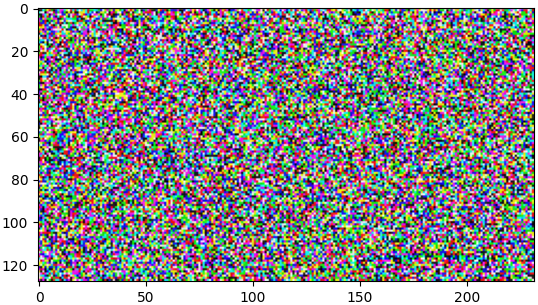

**Segmentation**
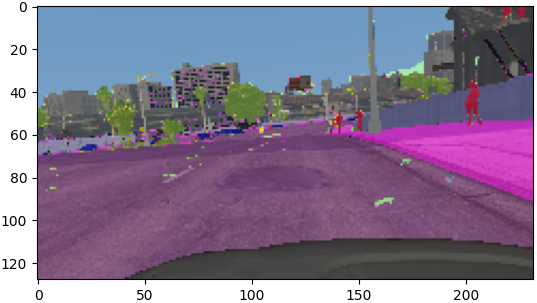

In [ ]:
### Instantiate the Denoising Dataset and plot the difference between the image and the noise.

train_data = GTAVDenoisingDataset()
noise, image = train_data.get_plottable(0)
plt.imshow(image - noise )

In [ ]:
###Instantiate the Segmentation Dataset and plot a sample masked image

train_data = GTAVSegmentationDataset()
train_data.plot_masked_im(0)

## 2. Autoencoder

In this section, we will go through the components of the autoencoder using a module approach. This means we will use `torch.nn.Module` to create custom layers that work cohesively with autograd and other torch modules. This approach makes reusing code convenient, but is not always memory efficient. To get around this, we will use `torch.nn.Sequential` to force torch to save smaller versions of the autograd graph for the different subcomponents of the final autoencoder - namely, the encoder, and the decoder. In general, one would want the output of the encoder for use in some 'downstream' task, so the encoder should contain less features than the input. We train both the encoder and decoder so that the encoder output actually contains useful information about the input images. 

In this Lab, we will instead use the encoder/decoder structure to denoise and segment images. This structure allows the model to learn a combined representation of both the image and the noise, as the bottleneck is forced to bridge the two. 

We will then write trainer classes, which are pretty standard practice in ML development, in order to keep the training and testing processes streamlined and all in one place. This is not *entirely* necessary, but we hope you find this workflow helpful. Many python packages exist to enhance this process, speed up training, and collect valuable information about your models, most of which start with this form of development. 

After writing our Trainer classes, we will use them to train our autoencoder on our datasets. The functionality we code into these Trainer classes will also be useful for the next model, and star of the show, the UNet. 

#### Double Convolution Layer

The most reused part of the architecture we are building is a double convolution layer. This Module has the optional utilities of being able to specify a middle channel count and of using residual connections.

**Question 1:** *What do residual connections do for models?* 

They are connections between non adjacent layers. Prevents vanishing and exploding gradients. But we do not use this in the lab?

- `__init__` : 
  - We will define an nn.Sequential layer to house the components of this Module (again, for faster backpropogation graphs).
    - Reference the diagram in the Diagrams pdf to implement the operations in this layer.
  - You will want to store the residual bool in self for use in the forward pass.
  - If no mid_channels is provided (is None), set it to out_channels, this is the default behaviour we want.
 
**Question 2:** *As can be seen in the diagram we set bias=False for the conv layers. Why don't we need biases in our convolutions here?*

The beta-parameter in our group-norm layer acts as a bias, we do not need to add it twice

**Question 3:** *What does padding do for us?*

Padding adds extra information around the image. This is useful for convolution as it allows all important pixels to be given equal weight in the next step of the model. Additionally it prevents the image from becoming smaller. 
     
- `forward()`: depending on that boolean we stored earlier, we will take one of two paths
    - if residual is `True`:
      - Pass $x$ to the double-convolutional sequential layer we defined in the initialization
      - Add the output to the input
      - Pass that sum to the GeLU activation function (`F.gelu()`)
      - return the result
    - else:
      - Pass $x$ to the double-convolutional sequential layer we defined in the initialization
      - Pass that output to the mish activation function (`F.mish()`)
      - Return the result
Remember, Modules, both native to torch or self defined, have to implement a forward operation so that we can call them like functions. Think of forward as being what happens when you call `module(x)` (python nerds: an autograd-ready version of the native python `__call__` method).

Torch also implements many of it's modules as functions, this is the difference between torch.nn and torch.nn.Functional (which we have already aliased as F).

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels = None, residual = False):
        
        super().__init__()
        
        self.residual = residual
        if (mid_channels is None):
            mid_channels = out_channels

        self.model = nn.Sequential(
                    nn.Conv2d(in_channels = in_channels, out_channels = mid_channels, kernel_size = 3, padding = 1, bias = False),
                    nn.GroupNorm(1, mid_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels = mid_channels, out_channels = out_channels, kernel_size = 3, padding = 1, bias = False),
                    nn.GroupNorm(1, out_channels))

    def forward(self, x):
        if (self.residual == True):
            return F.gelu(self.model(x) + x)
        else:
            return F.mish(self.model(x))



##### A small note on activations

While you have probably heard of the popular ReLU activation function, you might have noticed that we did not use it here. In fact, we used three differrent activations.

"Why is that?" you may ask.

ReLU happens to have an issue in that it does not allow for any negative responses, which has been shown to cause feature spaces to adapt in weird ways. Allowing for small negative responses makes a big difference in training models with high numbers of parameters. SiLU (a.k.a. Swish), GeLU, and Mish are all very similar functions in that they look like ReLU in the first quadrant, but allow small negative output values for small negative input values. 

They differ in very subtle ways, which makes them worth playing around with in research and industry, but suffice to say that there is a trade off between input domain and gradient quality. SiLU gives balanced gradients to a wide input range, while GeLU has a similar domain to SiLU and gives more aggressive gradients to positive input values. Mish has a smaller domain and stronger negative activations and gradients. 

We hope, in this lab, to show you some of the newer options that are available. When implementing practical deep learning models it is good to be aware of these and not just resort to a default choice. While we do not require you to experiment with this design choice in this lab, we have done some basic evaluation of different activation functions and came up with these ones as reasonable choices. This illustrates how the choice of activation function in practice can be seen as a hyperparameter that is tuned to optimize validation performance.

(TAs note: If you are interested in this kind of finite control, it can be a fun exercise to look at the different functions' domains, ranges, and first derivatives and get a feel for which ones will work where.)

##### A small note on GroupNorm

While you have probably heard of the popular normalization layer, BatchNorm, you might have noticed that we did not use it here. In fact, we used GroupNorm.

"Why is that?" you may ask.

GroupNorm is an newer alternative to BatchNorm which uses the statistics of the channel dimmension instead of the batch dimension. It was created to fix problems with BatchNorm, specifically related to noisy estimates of the batch statistics when working with small batch sizes. We found it to be quite helpful in the UNET you will train this week (we will use a relatively small batch size due to hardware constraints). If you want to learn more about GroupNorm we suggest having a look at the [https://arxiv.org/abs/1803.08494](paper).

A lot of machine learning research is knowing what alternatives there are and being open to try them, which is why we want to show you more recent findings in these labs. 

#### Downsampling Layer

This Module is used to reduce the size of the image by half and apply a few DoubleConvs. Refer to the diagram on the Diagrams pdf to implement this module.

You can define a single `nn.Sequential` in `__init__` for the series of modules on the diagram.

You can return the output from passing $x$ to that `nn.Sequential`.

In [ ]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        ####
        # Add Stuff here #
        ####
        self.sequential = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(
                in_channels,
                in_channels,
                residual=True),
            DoubleConv(
                in_channels,
                out_channels)
        )
        
    def forward(self, x):
        ####
        # Add Stuff here #
        ####
        x = self.sequential(x)
        return x 

#### Upsampling Layer

In the autoencoder, this Module is used to double the size of the image and apply a few DoubleConvs. Refer to the diagram in the Prelimanry/Diagrams pdf to implement this module.


You can define a single `nn.Sequential` in `__init__` for the series of modules on the diagram.

You can return the output from passing $x$ to that `nn.Sequential`.

We will be modifying this slightly for the UNet implementation.

In [ ]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.model = nn.Sequential(
                    nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True),
                    DoubleConv(in_channels = in_channels, out_channels = in_channels),
                    DoubleConv(in_channels = in_channels, out_channels = out_channels, mid_channels = in_channels//2))
                
        
    def forward(self, x):
        return self.model(x)

#### Autoencoder

We can now put these three components together to make our autoencoder. We will build it in two separate parts - an encoder, and a decoder. 

- `__init__`:
  - Define the encoder and decoder class variables as `nn.Sequential()` layers and follow the diagram in the Diagrams pdf to line up the requisite pieces of each. 
  - After setting up the encoder and decoder, we will use the included `denoising` boolean to make our final `nn.Sequential` layer dependent on the task. It will have a stack of convolution layers and an activation.
    - `denoising=True`:
      - Convolutions:
        - input channels is equal to the output channels of the decoder
        - output channels is equal to 3
        - kernel_size=1
      - nn.Sigmoid()
    - `denoising=False` (segmentation):
      - Convolutions:
        - input channels is equal to the output channels of the decoder
        - output channels is equal to 20
        - kernel_size=1
      - nn.Softmax(1)
        - *the 1 makes it perform its function on the 1st, or channel-wise, dimension*
- `forward()`:
  - return final_activation(decoder(encoder(x)))
    - this line won't *just work*, you gotta pythonify it

**Question 4:** *As can be seen in the block diagram for the AE, the final encoder (resp. first decoder) layer correspond to linear transformations that map the hidden state to (from) a 64-dimensional latent representation. What is the dimension of the input (output) to this linear layer? N.B. 

This depends on the dimensions of the convolutional layers.*  464, only downsampling matters, the padding and convolution takes out eachother in this case. H

**Question 5:** *Given how nn.Modules work, how could one get the encoded representation from the autoencoder?* 

Can exit after calling the encoding function

**Question 6:** *Why does the number of output channels differ for the two tasks? What do Sigmoid and Softmax do that makes them well suited as final layers relative to the tasks they were chosen for?* 

We need 3 channels for denoising one for each colour value for a pixel and 20 channels for segmentation, here it correlates to the different output classes. Softmax is used for the second task as it gives the probability that a prediction belongs to each class. We want to map all outputs between 0 and 1 as that is how the colours is scaled and for this the sigmoid function is useful. Softmax is a generalization of simoid that is useful for more classes.

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, denoising=False): 
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        super().__init__()
        channel_list = [32,64,128,256]
        self.encoder = nn.Sequential(
                    DoubleConv(3, channel_list[0]),
                    Down(channel_list[0], channel_list[1]),
                    Down(channel_list[1], channel_list[2]),
                    Down(channel_list[2], channel_list[3]),
                    DoubleConv(channel_list[3], 1),
                    nn.Flatten(),
                    ##need to put param before 64, should be able to run and see which size is needed
                    nn.Linear(464 ,64))
                    
        
        self.decoder = nn.Sequential(
                    nn.Linear(64, 464),
                    nn.Unflatten(-1,(1, 16, 29)),
                    DoubleConv(1, channel_list[3]),
                    Up(channel_list[3], channel_list[2]),
                    Up(channel_list[2], channel_list[1]),
                    Up(channel_list[1], channel_list[0]))
        
        if (denoising): 
            self.decoder_out = nn.Sequential(
                            nn.Conv2d(channel_list[0], 3, 1),
                            nn.Sigmoid())
        else:
            self.decoder_out = nn.Sequential(
                            nn.Conv2d(channel_list[0], 20, 1),
                            nn.Softmax(1))
            
        
    def forward(self, x):
        return self.decoder_out(self.decoder(self.encoder(x)))

## 3. Training Classes

#### DenoisingTrainer

The first training class we will make is the DenoisingTrainer. We have provided the call structure for the initialization as well as the train and test methods. Let's start with `__init__`.

**`__init__`**

First save the model to a class variable. 
- It will be passed as a class and not an object, so you will need to initiate the class as an object. Be sure to pass `True` to the denoising flag (since we are currently implementing the denoiser)
  - When you do this, it will initialize the Module much the same way as the Modules we initialized when we built up the autoencoder in the previous step.
- In order to get it to run quickly on the GPU, we will immediately use the Module's `.to()` method to define the device and dtype as self.device and torch.float, respectively. 

Once the model is defined, we will need our training and testing data and optimizer. 
- For the Data, we will follow a similar process to the model.
  - For this Trainer, we will use the GTAVDenoisingDataset
    - We can initialize both the training and testing data by passing them to the torch Dataloader class, which we will use to shuffle the data.
  - The DataLoader will take three arguments - dataset, batch_size, and a boolean, shuffle.
    - Because of how we set up the Datasets, we can initialize the two we need separately and simply pass the correct boolean value for the train argument.
    - The batch_size is a local variable in `__init__` and we can pass it as is
    - Shuffle should be set to True
- For the optimizer, which is once again a class and not an object (you know what to do), we will need to pass two variables - params and lr (learning rate)
  - To pass the parameters to the optimizer, we can call the `.parameters()` method of the model we initialized a bit ago
  - lr is an attribute (`self.`) and we can pass it as is

**`train`**

We have provided some of the looping and printing of this method to save time. We only need to add the actual per-batch machine learning methodology.

We defined a pbar (progress bar) using the tqdm module, this prints a nice loading bar as we run through an epoch. The structure $e$, ($x$, $y$) unpacks the training set and assigns an index to each step, per-batch. 
- In order to make sure our inputs and targets are on the same device as the model, we will resave the $x$ and $y$ arguments by calling the same `.to()` method call we used on the model in `__init__` on each of them.
- We can get a prediction by simply calling our model on the input, $x$
- To get our loss, we will call the loss function. It takes it's arguments in the order: (prediction, target).

**Question 7:** *What loss function should we use for this task? Think about what the model outputs and the goal.* We choose to use MSE as this does not only punish wrong predictions but it is also important how wrong the prediction is. If the model is very certain of a specific output but this output is wrong then this should be punished harder.
   
- *Gradient Descent:* Once we have our loss, we will take three actions to calculate and apply the gradients to the parameters of the model.
  - First, the optimizer has a method called `.zero_grad()`. It doesn't return anything, so call it outright.
    - *This will make sure each step applies its own gradients. In PyTorch, the optimizer will, by default, accumulate the gradients, which is useful in many contexts. The community has decided it is easier to add this extra step than to modify the entire PyTorch codebase for switching this behaviour on and off.*
  - Second, we will call the `.backward()` method on the loss (yes, the tensor, all torch tensors have this method). Once, again, this does not return anything so just call it outright.
    - *Unless explicately declined, PyTorch assumes every tensor object requires it's gradient to be tracked in the AutoGrad graph, though it hides most of this in the background. What this means is that, when we define a forward pass, we also define a backward pass, based on the chain-rule. When we call `.backward()`, torch uses the values of the inputs and the loss in this stored backward pass to efficiently calculate the individual partial derivatives of each parameter (i.e., the gradient).*
  - Finally, we simply call the optimizer's `.step()` method (also no return).
    - *This applies the optimizer's logic to the gradients (which were calculated by `loss.backward()` and stored in the .parameters of the model automatically) as well as the learning rate, to update the parameters. Some optimizer logic uses only the learning rate (SGD) while others incorporate momentum and other estimates of the second-order derivatives to improve training.*
 
**`test`**

We will have you do a bit more of the legwork in the `test()` method. Testing does not require us to keep track of the AutoGrad graph, so we use the decorator `@torch.inference_mode()` to tell torch not to track the graph during testing.

**Question 8:** *What is a decorator?* 
Decorators are functions themselves that wrap around other functions or methods, adding some additional functionality to them.

**Question 9:** *Torch provides functionality to disable gradients also with `@torch.no_grad()`. Why do we want to use inference mode instead?*
 torch.no_grad() disables gradient calculations, torch.inference_mode() goes a step further by also disabling certain internal checks and operations, leading to improved performance during inference.

- Following how we did so in `train()`, make a pbar and loop through it so we end up with an $e$ (enumeration), $x$ (input), and $y$ (target)
  - Remember, we are using the test data this time
- In the loop:
  - Use `.to()` to send $x$ and $y$ to the same device and dtype (datatype) as the model
  - Get a prediction from the model
  - Calculate the `noiseAccuracy`, using the included function, and add it to the total accuracy
    - make sure to use `.item()` so the value remains a python-native float
  - set `total_steps` = $e$ so the final printing of the accuracy knows how many steps went by
  - Display the accuracy as a post_fix in the pbar. You can get the accuracy at the current step by diving the total accuracy by $e$

In [ ]:
class DenoisingTrainer():
    def __init__(self, model, batch_size,  opt, lr):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        self.batch_size = batch_size
        self.lr = lr
        self.optimizer = opt(self.model.parameters(), lr = lr)


        self.dataset_train = GTAVDenoisingDataset()

        self.train_data = DataLoader(
            self.dataset_train,
            batch_size=batch_size,
            shuffle=True
        )
        
        self.dataset_test = GTAVDenoisingDataset(False)

        self.test_data = DataLoader(
            self.dataset_test,
            batch_size=batch_size,
            shuffle=True
    )
        
        
    def train(self, epochs):
        loss_history = torch.zeros((5))
        lh = []
        start = time.time()
        for epoch in range(epochs):
            print('Epoch: ', epoch+1)
            pbar = tqdm(self.train_data)
            for e,(x,y) in enumerate(pbar,1):

                x = x.to(self.device)
                y = y.to(self.device)
          
                self.optimizer.zero_grad()
                outputs = self.model(x)
                loss = F.mse_loss(outputs, y)
                loss.backward()
                self.optimizer.step()
                n = min(e,5) 

                ##########Hur nödvändigt? Bara för att få nya lossdatan?
                outputs = model(x)
                loss = F.mse_loss(outputs, y)
                
                loss_history[e%5] = loss.item() 
                lh.append(loss.item())
                # this line will print the rolling loss average on the progress bar
                pbar.set_postfix(Loss = (loss_history.sum()/n).item())
        print('Total Training Time: ', time.time() - start)
        return lh
        
    @torch.inference_mode()
    def test(self):
        # This function calculates the mean average distance of the pixels 
        ### and subtracts it from 1 to get an accuracy
        def noiseAccuracy(predicted, target):
            size = target.flatten().shape[0]
            true = (predicted - target).abs().mean()
            return 1-true
            
        total_accuracy = 0
        start = time.time()
        total_steps = 0
        pbar = tqdm(self.test_data)
        for e,(x,y) in enumerate(pbar,1):
            #to dtype in train to?
            x = x.to(self.device, dtype=torch.float32)
            y = y.to(self.device, dtype=torch.float32)
            pred = self.model(x)
            total_accuracy += noiseAccuracy(pred, y).item()
            total_steps = e
            pbar.set_postfix(Loss = (total_accuracy/total_steps))
    
        print('Noise Accuracy: ' + str((total_accuracy/(total_steps-1))))
        print('Total Eval Time: ', time.time() - start)
        

#### SegmentationTrainer

**`__init__`**

For the SegmentationTrainer, the init will follow the same steps as in DenoisingTrainer. This time the dataset will be the GTAVSegmentationDataset, and the model's denoising flag will be set to `False`.

**`train`**

We have once again provided some of the looping and printing of this method to save time. We only need to add the actual per-batch machine learning functionality, but this time with some minor modifications.

- One-hot encoding the target, $y$: the labels come in as tensors with the shape (batch_size, channels, height, width), where channels=1 and contains an unsigned-integer value of the correct class label. We need to turn this into a one-hot encoding, meaning `channels=20` (the number of classes) where all the values are zero except the correct label.
  - `nn.functional` (F) provides the convenient `one_hot()` method for us, but we have to do some dimension gymnastics for it to work
    -  `F.one_hot()` expects two arguments, tensor and num_classes.
      - *tensor:* We need the data to be integers (not unsigned integers), and to have no channel dimension
        - cast the $y$ variable to int
        - squeeze the 1st dimension 
      - *num_classes*: This is straightforward
  - The output of `F.one_hot` is also a tensor, but the channel dimension is last, so we will permute the last dimmension into the 1st dimmension (0,3,1,2)
  - Lastly, send the tensor to the model device and dtype, as per usual.
- The loss function we will use this time is `F.cross_entropy`, it works to make one probability distribution more similar to another.
  - Our predictions come out as class-probabilities, and our one-hot encoded labels are distributions where all the density is in one value, so this loss function works nicely.
  - We do, however, have another *problem* of sorts. The classes in this dataset are extremely unbalanced, which means some classes show up much more frequently on a per-pixel basis. This can make the model ignore less-frequent classes.
    - We can correct this by passing class weights to the cross_entropy loss. We have included the lines to collect class counts every step of training and build a moving distribution, so all you have to do is pass temperature-adjusted probabilities (you can [read about this](https://arxiv.org/abs/1503.02531) if you are interested) of each class as a third parameter to `F.cross_entropy()`.
      - The ce_weights class variable contains the totals
      - the `reweight()` class method will turn them into a temperature-adjusted distribution.
      - Call this function on the weights before you pass them to the loss function.
- The last three steps are identical to the *Gradient Descent* subsection of the DenoisingTrainer instructions.


 
**`test`**

We will once again write the testing loop. Go ahead and make a pbar and iterate through it, send $x$ and $y$ the model's device and dtype, and get the model predictions. We will be keeping track of three things per iteration:

- Increment total_accuracy with the output from the `pixelAccuracy` function. This comes out as a single value tensor but needs to be a python native float. Do you recall how we've fixed this before?
- Increment `confusion_matrix` with the output from the `confusionMatrix` function. This returns a tensor the same size as `confusion_matrix` already is, so nothing more to do here than add it.
- Increment `ground_truth` using the actual per-class pixel counts. This can be calculated for the current batch by calling `y.flatten().bincount(minlength=20)`. Once again, this returns the same shape tensor as it is being added to.
- Finally, set the `total_steps` to $e$ and print the current accuracy as a post_fix on the pbar. Refer to the denoising class for how to do this if you get lost.

**Question 10:** *What does a confusion matrix show us?* It shows how many TP, FP, FN, TN which allows us to calculate how the model performs with this training. 

The rest of the included functionality will output the confusion matrix nicely with the total pixel accuracy as a title. 

Feel free to try to read and understand the included functions for calculating this matrix. It isn't so difficult, but could be a bit tedious for a time limited lab setting.


In [ ]:
class SegmentationTrainer():
    def __init__(self, model,  batch_size,  opt, lr):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.ce_weights = torch.ones((20)).to(self.device)
 
        self.model = model.to(self.device)
        self.batch_size = batch_size
        self.lr = lr
        self.optimizer = opt(self.model.parameters(), lr = lr)


        self.dataset_train = GTAVSegmentationDataset()

        self.train_data = DataLoader(
            self.dataset_train,
            batch_size=batch_size,
            shuffle=True
        )
        
        self.dataset_test = GTAVSegmentationDataset(False)

        self.test_data = DataLoader(
            self.dataset_test,
            batch_size=batch_size,
            shuffle=True
        )
        
    def train(self, epochs):
        start = time.time()
        loss_history = torch.zeros((5))
        lh = []
        for epoch in range(epochs):
            print('Epoch: ', epoch+1)
            pbar = tqdm(self.train_data)
            for e,(x,y) in enumerate(pbar,1):
                self.ce_weights += y.flatten().int().bincount(minlength=20).to(self.device)
             
                x = x.to(self.device, dtype=torch.float32)
                y = y.long()
                y = torch.squeeze(y, 1)
                y = F.one_hot(y, 20)
                y = y.permute(0,3,1,2)
                y = y.to(self.device, dtype=torch.float32)
                
                self.optimizer.zero_grad()
                outputs = self.model(x)
                self.ce_weights = self.reweight(self.ce_weights)
                loss = F.cross_entropy(outputs, y, self.ce_weights)
                loss.backward()
                self.optimizer.step()
                outputs = model(x)
                loss = F.cross_entropy(outputs, y, self.ce_weights)
                n = min(e,5)
                loss_history[e%5] = loss.item()
                lh.append(loss.item())
                pbar.set_postfix(Loss = (loss_history.sum()/n).item())
        print('Total Training Time: ', time.time() - start)
        return lh
        
    def reweight(self, w):
        w_ = (1 - (w/w.sum())**.005)
        return  w_/w_.sum()

    @torch.inference_mode()
    def test(self):
        def meanLerp(vals):
            vals = (vals)/(vals.max())
            return vals
        def confusionMatrix(predicted, target):
            predicted_guess = predicted.argmax(1)
            cated = torch.cat((target, predicted_guess.unsqueeze(1)),dim=1)
            return (cated[:,-2] * 20 + cated[:,-1]).flatten().bincount(minlength=400).reshape((20,20))
            
        def pixelAccuracy(predicted, target):
            size = target.flatten().shape[0]
            predicted_guess = predicted.argmax(1)
            true = (predicted_guess.unsqueeze(1) == target).int().sum()
            pa = true / size #(h * w * batch_size)
            return pa
            
        start = time.time()
        total_accuracy = 0
        total_steps = 0
        confusion_matrix = torch.zeros((20,20)).to(self.device)
        ground_truth = torch.zeros((20)).to(self.device)
        pbar = tqdm(self.test_data) ## Fix this

        for e,(x,y) in enumerate(pbar,1):
            #to dtype in train to?
            x = x.to(self.device, dtype=torch.float32)
            pred = self.model(x)
            y = y.long()
            y = y.to(self.device)
            confusion_matrix += confusionMatrix(pred, y)
            ground_truth += y.flatten().bincount(minlength=20)

            #bincount requires a int
            y = y.to(dtype=torch.float32)
            total_accuracy += pixelAccuracy(pred, y).item()
            total_steps = e
            pbar.set_postfix(Loss = (total_accuracy/total_steps))
    
        
        cm_im = torch.ones((20,20,3))
        cm_im[:,:,0] = torch.diag(meanLerp(ground_truth))  
        cm_im[:,:,1] = meanLerp(confusion_matrix)
        cm_im[:,:,2] *= .25
        fig = plt.figure()
        ax = fig.add_subplot(111)
        im = ax.imshow(cm_im )
        #why total_steps - 1
        ax.set_title('Pixel Accuracy: ' + str((total_accuracy/(total_steps-1))))
        ax.set_xticks(list(range(20)))
        ax.set_yticks(list(range(20)))
        plt.show()
        print('Total Eval Time: ', time.time() - start)



### Define Constants and run the training - autoencoder

Recall from when we setup our Trainer classes that we need 4 parameters, plus one for training:

For the trainer:
- *model*: This will be our autoencoder, this time. *Remember to pass it as a class and not an object!*
- *batch_size*: This variable can have a huge effect on training, but in this limited-hardware lab environment, we found that 8 works best.
- *opt*: There are many of these on the [torch.optim website](https://pytorch.org/docs/stable/optim.html), but we found quite solid results from RAdam. *Remember to pass it as a class and not an object!*
- *lr*: Play with this if you have time, it affects how fast your model will converge and how likely it is to get stuck in a local minima, but we found .001 to work well.

And for training:
- *epochs*: The longer it runs the better it should perform, 10 will be enough to get the point across.
  
Once we have defined our model, we need to train it. Call the train method (don't forget to pass it the number of epochs).
  - This method returns a list of losses. If you want to plot this:
    - catch the output of `.train()` in a variable
    - use `plt.plot()` to plot it. This will need to pass x values and y values
      - the $x$ values can be aquired quickly by calling list(range(len(loss_history))). This line is long, but all it does is make a list of values from 0 til however long the history is
      - the $y$ values are the loss history
  - Note that not catching the loss history will not stop the model from training, the returned list will just vanish.

**DEMO 3:** **_Once trained, call `model.test()` to run the model on the test set and see the accuracy._**

**DEMO 4:** **_Once you have done this for the Denoising task, copy this cell and try this model on the Segmentation task. 
You will need to change the Trainer._** 

In [ ]:
SEED = 1969
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.empty_cache()

#model = AutoEncoder(True)
model = AutoEncoder(False)
batch_size = 12
opt = torch.optim.Adam
lr = 0.001
##trainer = DenoisingTrainer(model, batch_size, opt, lr)
trainer_s1 = SegmentationTrainer(model, batch_size, opt, lr)

trainer_s1.train(10)

trainer_s1.test()

In [ ]:
SEED = 1969
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.empty_cache()

model = AutoEncoder(True)
#model = AutoEncoder(False)
#Crash på batch size 30
batch_size = 12
opt = torch.optim.Adam
lr = 0.001
trainer_d1 = DenoisingTrainer(model, batch_size, opt, lr)
##trainer = SegmentationTrainer(model, batch_size, opt, lr)

trainer_d1.train(10)

trainer_d1.test()

In [ ]:
### This box will show the ground truth mask overlayed above the image, 
### as well as the model predicted mask overlayed above the image, for comparison
index = 16 # some number less than 500
test_data = GTAVSegmentationDataset(False)
test_data.plot_pred_masked_im(index,trainer_s2.model)
test_data.plot_pred_masked_im(index,trainer_s1.model)

##### Validation

In machine learning, it is important **not** to use your test data to make decisions about your model hyperparameters. Instead, we use a subset of the available training data as validation data for this purpose. Since we picked all the hyperparameters for you, we chose to leave this out for the scope of the lab, but it is **_very important_** to know the distinction between validation and test data and not make the mistake of tuning your model's hyperparameters based on test data in research. 

## 4. UNet

Now that we have seen the autoencoder's performance on both denoising and segmentation, we can hopefully tell that it needs a bit of help with segmentation. The random noise used to generate the noisy images is relatively uniform in all the images, so contextual information about different locations in the image are not needed. For segmentation, our model needs to have a way to associate the input features to the output features more often. To accomplish this, we will use what are called skip connections. 

Skip connections simply take the outputs from the encoder side of the autoencoder and pass them over to the decoder side, concatenate them and let the double convolutions handle the rest. 

**Question 11:** *How do skip connections improve our model?* We have access to more information when rebuilding our image. 

Storing and concatenating outputs is, unfortunely, one thing we cannot do with Sequential layers, so we will have to deconstruct a few of our previous modules to accomplish this. 

#### UNet - UpSkip

First we will need to modify our Up layer a bit. Let's copy it down here and make some edits. These will be nice and simple. 

- For the `__init__` method, take the UpSample Module out of the Sequential and make it its own self variable
- For the `forward` method
  - Modify it to take three inputs instead of two, namely $self$, $x$, and $skip\_x$ (which comes from the encoder branch).
  - Run $x$ through the upsample layer, then use torch.cat to concatenate the upsampled output and $skip\_x$ along the 1st dimension.
  - Finally, return the output from passing the contatenated input into the convolution Sequential layer.

There is another diagram in the Diagrams pdf to help.

In [ ]:
class UpSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
 
        self.up_sampling = nn.Upsample(
                scale_factor=2,
                mode='bilinear',
                align_corners=True
            )
        self.sequential = nn.Sequential(
            DoubleConv(
                in_channels,
                in_channels
            ),
            DoubleConv(
                in_channels,
                out_channels,
                in_channels//2
            )
        )
        
    def forward(self, x, skip_x):
        
        x = self.up_sampling(x)
        x = torch.cat((x, skip_x), dim=1)
        x = self.sequential(x)
        return self.model(x)

#### UNet - New Structure

Now that we have our skip-connection-ready Upsampling layer, we can fix up the UNet. This Module will be quite similar to the autoencoder we made before, so go ahead and copy it down here (aside from the class name) and we will make some edits. There is another diagram in the Diagrams pdf for helping set up the new model. 

Much like in UpSkip, we will have to take some Modules out of the Sequential layers we made before.
  - In fact, in order to collate the outputs we need for the skip connections to work, we will need every module to have its own class variable (though not the ones within the bottleneck since the bottleneck gets its own).
  - This bottleneck will also be a bit different than the one used in the autoencoder since this model is not designed to output it's encoder features. We will instead stick to a setup similar to the original UNet paper.
  - In the diagram, there is a box around the bottleneck, implying it is an nn.Sequential, the rest **should not be**.

At this point, `__init__` should contain 7 standalone layers with their own class variables 
- a DoubleConv for the input
- two standalone Down
- the bottleneck
- three standalone UpSkip.

The switch we made for the encoder to output the correcly shaped output depending on whether it was denoising or not should be the same.

When we perform our forward pass, we will call each layer individually and specify which outputs to store and which ones to rewrite. This part may get tricky, but using what you know about skip connections and the diagram on the handout, try and rewrite the forward method of the UNet Module. 

In [ ]:
class UNet(nn.Module):
    def __init__(self, denoising=False): 
        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        channel_list = [32,64,128,256]
     
        
        self.DC =  DoubleConv(3, channel_list[0])
        self.Down1 = Down(channel_list[0], channel_list[1])
        self.Down2 = Down(channel_list[1], channel_list[2])
        self.BottleNeck = nn.Sequential(
                            Down(channel_list[2], channel_list[3]),
                            DoubleConv(channel_list[3], channel_list[3]),
                            DoubleConv(channel_list[3], channel_list[3]),
                            DoubleConv(channel_list[3], channel_list[2]))
        #Gissat på siffror ovan, fel dimension?
        
        self.UpSkip1 = UpSkip(channel_list[3], channel_list[1])
        self.UpSkip2 = UpSkip(channel_list[2], channel_list[0])
        self.UpSkip3 = UpSkip(channel_list[1], channel_list[0])
                
        if (denoising): 
            self.UNet_out = nn.Sequential(
                            nn.Conv2d(channel_list[0], 3, 1),
                            nn.Sigmoid())
        else:
            self.UNet_out = nn.Sequential(
                            nn.Conv2d(channel_list[0], 20, 1),
                            nn.Softmax(1))
            

        

                   ## Vad är detta decoder_out()) DEN SKA VARA HÄR
        .9749448691926351
    def forward(self, x):
        x1 = self.DC(x)
        x2 = self.Down1(x1)
        x3 = self.Down2(x2)
        b = self.BottleNeck(x3)
        y3 = self.UpSkip1(b, x3)
        y2 = self.UpSkip2(y3, x2)
        y1 = self.UpSkip3(y2, x1)
        
        return self.UNet_out(y1)

In [ ]:
SEED = 1969
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.empty_cache()

model = UNet(True)
batch_size = 12
opt = torch.optim.Adam
lr = 0.001
trainer_d2 = DenoisingTrainer(model, batch_size, opt, lr)

##trainer = SegmentationTrainer(model, batch_size, opt, lr)

trainer_d2.train(10)

trainer_d2.test()

### Define Constants and run the training - UNet

Thankfully, we can just reuse our code from before and specify the Unet instead of the autoencoder. This may take a bit longer to train.

**DEMO 5:** Train and test the UNet on the Denoising dataset

**DEMO 6:** Train and test the UNet on the Segmentation dataset

In [ ]:
SEED = 1969
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.empty_cache()

model = UNet(False)
batch_size = 12
opt = torch.optim.Adam
lr = 0.001
##trainer = DenoisingTrainer(model, batch_size, opt, lr)

trainer_s2 = SegmentationTrainer(model, batch_size, opt, lr)

trainer_s2.train(1)

trainer_s2.test()

In [ ]:
trainer_s2.test()

## 

In [ ]:

save_path ='models.pth'
model_d1 = trainer_d1.model
model_s1 = trainer_s1.model
model_d2 = trainer_d2.model
model_s2 = trainer_s2.model

#torch.save({'trainer_d2':trainer_d2,'model_d2':model_d2.state_dict(),'trainer_s2':trainer_s2,'model_s2':model_s2.state_dict(),'trainer_d1':trainer_d1,'model_d1':model_d1.state_dict(),'trainer_s1':trainer_s1,'model_s1':model_s1.state_dict()},save_path)
torch.save({
    'model_d1_state_dict': model_d1.state_dict(),
    'model_s1_state_dict': model_s1.state_dict(),
    'model_d2_state_dict': model_d2.state_dict(),
    'model_s2_state_dict': model_s2.state_dict()
    # Optionally, you can save the trainers as well if needed
    # 'trainer_d1': trainer_d1,
    # 'trainer_s1': trainer_s1,
    # 'trainer_d2': trainer_d2,
    # 'trainer_s2': trainer_s2,
}, save_path)



## 

In [ ]:

load_path = 'models.pth'

# Load the checkpoint
checkpoint = torch.load(load_path)


# Instantiate the models
model_d1 = AutoEncoder(True)
model_s1 = AutoEncoder(False)
model_d2 = UNet(True)
model_s2 = UNet(False)

# Load the state dictionaries of the models
model_d1.load_state_dict(checkpoint['model_d1_state_dict'])
model_s1.load_state_dict(checkpoint['model_s1_state_dict'])
model_d2.load_state_dict(checkpoint['model_d2_state_dict'])
model_s2.load_state_dict(checkpoint['model_s2_state_dict'])


opt = torch.optim.Adam
trainer_d11 = SegmentationTrainer(model_d1, 10, opt, 0.001)
trainer_s11 = SegmentationTrainer(model_s1, 10, opt, 0.001)
trainer_d21 = SegmentationTrainer(model_d2, 10, opt, 0.001)
trainer_s21 = SegmentationTrainer(model_s2, 10, opt, 0.001)

print('test')

#### Visualising Denoising Post-Training

This cell can be used to print the noise images ground truth and prediction and their differences from the ground truth image. The first variable allows you to easily switch and compare outputs if you decide to try EMA (see below).  

In [ ]:
model2use = trainer_d2.model

def lerp(x):
    min_ = x.min()
    max_ = x.max()
    return (x - min_) / (max_ - min_)
index = 1002
x, y = (GTAVDenoisingDataset(True)[index])
x, y = (x).unsqueeze(0).to(trainer_d2.device), (y).unsqueeze(0).to(trainer_d2.device)
with torch.inference_mode():
    pred = model2use.forward(x).squeeze(0).cpu()
fig = plt.figure()
ax1 = fig.add_subplot(221)
#y.squeeze(0).cpu().transpose(2,0).transpose(1,0)
ax1.imshow(x.squeeze(0).cpu().transpose(2,0).transpose(1,0))
ax2 = fig.add_subplot(222)
ax2.imshow(pred.transpose(2,0).transpose(1,0))

diff_n = x.squeeze(0).cpu().transpose(2,0).transpose(1,0) - y.squeeze(0).cpu().transpose(2,0).transpose(1,0)

ax3 = fig.add_subplot(223)
ax3.imshow(lerp(diff_n))

diff_p = pred.transpose(2,0).transpose(1,0) - y.squeeze(0).cpu().transpose(2,0).transpose(1,0)

ax4 = fig.add_subplot(224)
ax4.imshow(lerp(diff_p))
print(str(pred.max().item()) + ' ' + str(pred.min().item()))
plt.show()

#### EMA

EMA or Exponential Moving Average, is a training method where we create a copy of a model for which to store the running average of the weights during training. We use a beta value to keep a percentage of the current average and 1 minus the beta value to modify the average slightly during every step of training. We set a start point for EMA so that the values do not start averaging before the model is anywhere near convergence. 

In order to try this out, make another model as a class variable in your Training classes, initiate them with the commented out line of code in the following cell. 

You will also need a class variable for the EMA class itself. The default beta value should work fine, but if you've time to try, play around with it in a run or two. 

Finally, during training, call the EMA object's step_ema() method by passing the Trainer's ema_model and model. Do this just after updating the weights with the optimizer. 

In order to test it, you will need to modify the test method in each to use the ema_model for testing instead. We suggest adding a boolean to the test function so you can choose this and compare the two after training.  

In [ ]:

## copy.deepcopy(self.model).eval().requires_grad_(False)

class EMA():
    def __init__(self, beta):
        self.beta = beta
        self.alpha = 1- beta
        self.step  = 0
    def move_averages(self, ema_model, model):
        for cur_mod, cur_ema in zip(model.parameters(), ema_model.parameters()):
            old_weight, new_weight  = cur_ema.data, cur_mod.data
            cur_ema.data = self.move_average(old_weight, new_weight)
    def move_average(self, old, new):
        return old * self.beta + new * self.alpha
    def step_ema(self,ema_model, model, start_ema=500):
        if self.step < start_ema:
            self.reset(ema_model, model)
            self.step += 1
            return
        self.move_averages(ema_model, model)
        self.step += 1
    def reset(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())